In [1]:
import re

import numpy as np
import pandas as pd

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from baseline.config import STOP_WORDS

In [2]:
# Load PR Newswire Annotated Dataset
pr_newswire = pd.read_csv("../data/pr-newswire.csv")

In [3]:
def text_cleaning(text: str):
    """Cleans raw text input for Doc2Vec."""
    ps = PorterStemmer()
    
    # Strip punctuation and special chars
    stripped = re.sub(r"[^\w]", " ", text)
    
    # Tokenize and stem words
    tokenized = [
        ps.stem(token.lower()) for token in stripped.split(" ")
        if token.strip() and token.lower() not in STOP_WORDS
    ]
    
    return tokenized

In [4]:
raw_news_stories = pr_newswire["data"]

# Establish data and target for vectorization
stories = list(map(text_cleaning, raw_news_stories))
classifications = list(pr_newswire["target"])

In [5]:
# Build Doc2Vec `TaggedDocument` array
documents = [
    TaggedDocument(story, classifications[idx]) for idx, story in enumerate(stories)
]

In [6]:
# Build Doc2Vec model
d2v = Doc2Vec(vector_size=40, min_count=2, epochs=30)
# Build vocabulary
d2v.build_vocab(documents)

In [7]:
# Train doc2vec
d2v.train(documents, total_examples=d2v.corpus_count, epochs=d2v.epochs)

In [8]:
# Destructure words and tags from TaggedDocument
words = [doc.words for doc in documents]
tags = [doc.tags for doc in documents]

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(words, tags, test_size=0.20)

In [9]:
# Build vectors for training
x_train_vectors = [
    d2v.infer_vector(instance) for instance in x_train
]

# Build LabelEncoder for training
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

# Encode training lables
y_train_labels = label_encoder.transform(np.asarray(y_train))

In [10]:
# Fit Logistic Regression on infered vectors
logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_train_vectors, y_train_labels)

LogisticRegression(max_iter=1000)

In [11]:
# Build vectors for testing
x_test_vectors = [
    d2v.infer_vector(instance) for instance in x_test
]

In [12]:
# Predictions
y_pred = logreg.predict(x_test_vectors)

In [13]:
# Encode test lables
y_test_labels = label_encoder.transform(y_test)

In [14]:
print(f"Classes: {logreg.classes_}")
print(f"Intercepts: {logreg.intercept_}")
print(f"Coefficient: {logreg.coef_}")

Classes: [0 1 2 3 4]
Intercepts: [-2.27650479  5.37801414 -3.28943025 -2.02564289  2.2135638 ]
Coefficient: [[ 8.47398417e-03  2.42474801e-01 -2.06024352e-01 -8.72151431e-02
   9.97281185e-02 -1.54858834e-02  6.87665093e-02  1.38645882e-01
  -2.79705313e-01  1.02054434e-02 -1.73168238e-01  2.54964421e-02
   7.47701528e-02 -4.04753425e-02  5.34764047e-02 -2.31087019e-01
  -8.85379568e-02  2.78927532e-01  9.38882371e-02 -4.32757770e-03
   5.95319522e-02  9.49008107e-02 -1.51984211e-01 -1.51204894e-01
  -2.03307192e-01  2.08503243e-01 -1.40060598e-01 -7.82351589e-02
   2.53485574e-02 -1.12816391e-01 -9.62168662e-02  2.10672463e-01
   1.37052417e-02  7.43842426e-02 -1.64100897e-02  8.68274264e-02
  -1.35165270e-01  2.64876780e-01  3.33347904e-01 -3.47186301e-01]
 [ 4.54433673e-01 -2.27132291e-01  3.92907778e-01  2.11779838e-01
   5.59875104e-02 -1.05532917e-01  2.93898146e-01 -3.07153091e-01
   2.22586368e-01 -7.90071538e-02  5.33443175e-02  2.77525612e-01
  -1.22079682e-01  2.40970313e-01

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score,
)

In [16]:
c_matrix = confusion_matrix(y_test_labels, logreg.predict(x_test_vectors))

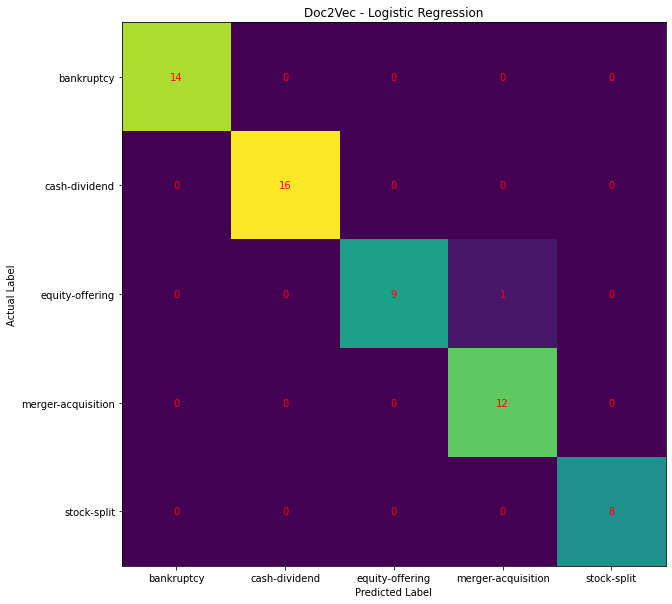

In [17]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(c_matrix)

ax.set_ylabel("Actual Label")
ax.set_xlabel("Predicted Label")
labels = tuple(label_encoder.inverse_transform([0, 1, 2, 3, 4]))
ax.xaxis.set(ticks=(0, 1, 2, 3, 4), ticklabels=labels)
ax.yaxis.set(ticks=(0, 1, 2, 3, 4), ticklabels=labels)
plt.title("Doc2Vec - Logistic Regression")
for i in range(len(labels)):  # ref: (https://realpython.com/logistic-regression-python/)
    for j in range(len(labels)):
        ax.text(j, i, c_matrix[i, j], ha='center', va='center', color='red')
plt.savefig("doc2vec-logistic-regression")

In [18]:
# Calculate key metrics
precision = precision_score(y_test_labels, y_pred, average="weighted")
recall = recall_score(y_test_labels, y_pred, average="weighted")
f1 = f1_score(y_test_labels, y_pred, average="weighted")

print(f"Precision Score: {precision}")
print(f"Recall Score: {recall}")
print(f"F1 Score: {f1}")

Precision Score: 0.9846153846153847
Recall Score: 0.9833333333333333
F1 Score: 0.9832280701754387


In [19]:
# Classification Report
print(classification_report(y_test, label_encoder.inverse_transform(y_pred)))

                    precision    recall  f1-score   support

        bankruptcy       1.00      1.00      1.00        14
     cash-dividend       1.00      1.00      1.00        16
   equity-offering       1.00      0.90      0.95        10
merger-acquisition       0.92      1.00      0.96        12
       stock-split       1.00      1.00      1.00         8

          accuracy                           0.98        60
         macro avg       0.98      0.98      0.98        60
      weighted avg       0.98      0.98      0.98        60

